# Lecture 8

## Logistic Regression
* What is pickle?
https://docs.python.org/2/library/pickle.html
* Random forest doesn't need to be normalized. 
* np.reshape(x_valid, (-1,28,28))
* Einstein Summation http://mathworld.wolfram.com/EinsteinSummation.html
* 3bluebrown linear algebra youtube
* computational linear algebra fast.ai
* kaiming he initialization tensorflow

**Remarks:**
* Random forests and decision trees are limited by the fact that they're basically doing nearest neighbors. They can't extrapolate out to, for example, what happens if I'll increase my prices by 20% and you've never priced at that level before. 

In [2]:
%load_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

## Download

In [3]:
path = '../data/'

In [4]:
import os
os.makedirs(path, exist_ok=True)

In [5]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

If you have any kind of Python object at all. you can use this build-in python library called pickle to dump it out onto your disk, share it around, load it up later, and you get back the same Python object you started with. Pickle is not just for pandas, it works for nearly every python object (but probably not likely optimal for nearly any Python object, so we use feather for df)

In [6]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME) # in this case we don't care about test data

mnist.pkl.gz: 16.2MB [00:01, 9.82MB/s]                            


In [7]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

784 = 28X28  
The word flatten is very common with working with tensors. When you flatten a tensor, it means you're turning it into a lower rank tensor than your start up with.  
* Vector, 1d array, rank 1 tensor  
* Matrix, 2d array, rank 2 tensor
* row = axis0, column = axis1
* If you're an image person, then x is the first axis, y is the second axis

## Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [8]:
mean = x.mean()
std = x.std()

In [9]:
x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

* Question for students:
Do you think it would be important to normalize the independent vairables for a random forest? NO. When we're deciding where to split, all that matters is the order. They totally ignore the outlier and only care about which one's higher than what other things.

Note that for consistency(with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. The following example is from *Python Machine Learning*
```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
```

In [10]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

## Look at the data

### Helper methods  

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [5]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

### Plots

In [13]:
x_valid.shape

(10000, 784)

* One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions. That being said, 10000*784/(28*28) = 10000

In [14]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

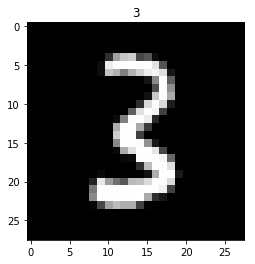

In [15]:
show(x_imgs[0], y_valid[0])

In [16]:
y_valid.shape

(10000,)

In [17]:
y_valid[0]

3

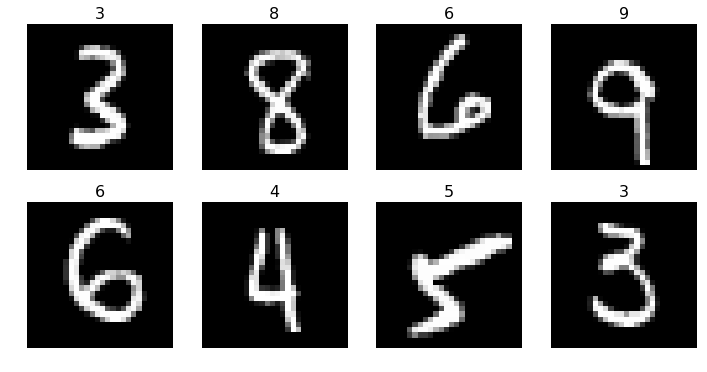

In [18]:
plots(x_imgs[:8], titles=y_valid[:8])

## Neural Networks
**What is a neural network?**  
A *neural network* is an infinitely flexible function, consisting of *layers*. A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*)

## Logistic regression

## PyTorch

With PyTorch, you can run it on the GPU rather than CPU.

**Launch a GPU computer on AWS:**  
Launch Instances --> Community AMIs --> search fastai --> Select --> Select GPU compute --> p2.xlarge  
(Check DL intro tutorial)


## Neural Net for Logistic Regression in PyTorch

In [7]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  
Sequential means I'm going to give you a list of the layers that I want in my neural network. In this case, my list has two things in it. The first things says I want a linear layer, which is something that's going to do y = ax+b. So it is going to do a matrix product basically. So the input of the matrix product is going to be a vector of length 28 times 28 (pixels we have). The output needs to be of size 10.

In [20]:
net = nn.Sequential(
    nn.Linear(28*28, 10), #because we want 10 predictions [0,10]
    nn.LogSoftmax()
).cuda() 
# cuda tells pytorch to copy this neural network across to the GPU so from now on that network is going to 
# be actually running on the GPU. If we didn't say that it would run on the CPU.

What does ImageClassifierData.from_arrays do is it creates a PyTorch data loader for us. A PyTorch data loader is something that grabs a few images and sticks them to a mini batch that makes them available. In Python, we call these things generators. Generators are things where you can basically say I want another, I want another, ...

In [21]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [22]:
x.shape

(50000, 784)

In [27]:
loss=nn.NLLLoss() #negative log likelihood loss
metrics=[accuracy]
opt=optim.Adam(net.parameters())

It is creating a matrix multiplication followed by a non-linearity and that is trying to find the values of this matrix which fit the data as well as possible. Then we optimize the loss function.

In [24]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y) * np.log(1-p)))

In [25]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

What the following code does is it goes through every images `epochs` (i.e. every image once in this case) and go into slightly update the values in that weight matrix based on those gradients. `crit` means the loss function.

In [28]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

[ 0.       0.31106  0.28607  0.91839]                        



In [ ]:
preds = predcit(net, md.val_dl)

In [ ]:
preds.shape

In [ ]:
preds.argmax(axis=1)[:5]

In [ ]:
preds = preds.argmax(1)

* [CHAPTER 4 A visual proof that neural nets can compute any function](neuralnetworksanddeeplearning.com/chap4.html)  
* Kaiming He Initialization

## Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer. This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`). Let's try defining this ourselves.

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the @ operator), PyTorch has `torch.matmul`.

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a preduction using those parameters) The method `forward` describes how the neural net converts inputs to outputs.  

In PyTorch, the optimizer knows to try to optmize any attribute of type **Parameter**.

In [39]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [42]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__() # if you inherit from some other object, then you have to create the thing you inherit from first
        self.l1_w = get_weights(28*28, 10) # Layer 1 weights
        self.l1_b = get_weights(10)        # Layer 1 bias
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b # Linear Layer
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0))) # Non-linear (LogSoftmax) Layer
        return x 

**Softmax:** (Activate function)
* The softmax function takes our outputs and turns it into something which behaves like a probability. we don't strictly speaking need it we could still try train something which where the output directly is the probabilities, but by softmax it is less for the network to learn so it's going to learn better.  
* Softmax will tend to make most of its activations pretty close to zero.

Why do we need define forward? This is a PyTorch specific thing. What's going to happen is when you create a module in PyTorch, the objects that you get back behaves as if it is a function. You can call it with parentheses. And so you need to somehow define when you call it as if it is a function. And the answer is PyTorch calls a method called forward. 

We create our neural net and the optimizer. (We will use the ssame loss and metrics from above)

In [44]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [45]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

[ 0.       2.44033  2.39819  0.90914]                       



In order to grab something that we can use to generate mini batches we have to take our data loader, and so you can ask for the training data loader from our model data object. You'll see there's a bunch of data loaders as you can ask for. 
```python
md.sz
md.test_aug_dl
md.trn_y
```

In [60]:
dl = iter(md.trn_dl) # turn something to a iterator.

In [61]:
xmb, ymb = next(dl)

The same as 
```python
for xmb, ymb in dl:
    ...
```

**What does Variable() do?**
This is how get free automatic differentiation.  
```
Docstring:     
Wraps a tensor and records the operations applied to it.

Variable is a thin wrapper around a Tensor object, that also holds
the gradient w.r.t. to it, and a reference to a function that created it.
This reference allows retracing the whole chain of operations that
created the data. If the Variable has been created by the user, its grad_fn
will be ``None`` and we call such objects *leaf* Variables.
```

In [70]:
vxmb = Variable(xmb.cuda()) # Because our net2 object is in GPU, so our data should also be in GPU. xmb.cuda()
vxmb # anything we do to Tensor we can do to a variable, but it's going to track of exactly what we did.

Variable containing:
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.cuda.FloatTensor of size 16x784 (GPU 0)]

In [71]:
preds = net2(vxmb).exp() # this is what he mentioned above, a object behaves as a function

In [73]:
preds[:3]

Variable containing:

Columns 0 to 5 
 7.6774e-03  2.7962e-02  1.2391e-01  2.3123e-02  2.8028e-04  6.3542e-03
 1.0150e-03  7.6249e-02  2.7831e-01  8.4787e-03  1.0334e-02  5.7037e-02
 3.1564e-04  5.1740e-01  1.3933e-02  6.0181e-03  3.9877e-02  1.1778e-02

Columns 6 to 9 
 1.9016e-02  2.1688e-07  1.0096e-02  5.3062e-07
 1.8217e-02  9.9552e-02  6.2370e-02  3.1343e-02
 1.0006e-02  7.2494e-02  1.8476e-01  1.7144e-01
[torch.cuda.FloatTensor of size 3x10 (GPU 0)]

So when we define our own architectures anywhere you would put in a function you could put in a layer, you can put it in a neural net. Because as PyTorch is concerned, they're all things that going to call just like as if they're functions. (?)  

In [75]:
preds.max(1)[1] # these are predictions

Variable containing:
 2
 2
 1
 0
 3
 2
 2
 6
 3
 1
 8
 6
 9
 5
 7
 3
[torch.cuda.LongTensor of size 16 (GPU 0)]

## Aisde about Broadcasting and Matrix Multiplication

Now let's dig in to what we were doing with `torch.matmul:` matrix multiplication. First, let's start with a simpler building block: **broadcasting.**

### Element-wise operations

Broadcasting and element-wise operations are supported in the same way by both numpy and python.

Operaters(+,-,\*,/,>,<.==) are usually element-wise. 

Examples of element-wise operations:

In [12]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])
a, b

(array([10,  6, -4]), array([2, 8, 7]))

In [8]:
a = T([10, 6, -4])
b = T([2, 8, 7])
a,b 

(
  10
   6
  -4
 [torch.LongTensor of size 3], 
  2
  8
  7
 [torch.LongTensor of size 3])

## Broadcasting

In [13]:
a

array([10,  6, -4])

In [14]:
a > 0 #rank one tensor vs. rank zero tensor

array([ True,  True, False], dtype=bool)

How are we able to do a > 0? 0 is being broadcast to have the same dimensions as a.

Remember above when we normalized our dataset by subtracting the mean(a scalar) from the entire data set (a matrix) and dividing by the standard deviation (anohter scalar)/ We wer using broadcasting!

Other examples of broadcasting with a scalar

In [15]:
a + 1

array([11,  7, -3])

### broadcasting a vector to a matrix

We can also broadcast a vector to a matrix

In [16]:
c = np.array([10, 20, 30]); c

array([10, 20, 30])

In [18]:
m = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [19]:
c + m

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [21]:
np.expand_dims(c, 1) # create a 3 x 1 tensor

array([[10],
       [20],
       [30]])

In [25]:
c[None] # create a new axis?

array([[10, 20, 30]])

In [26]:
c[:, None] # conver to 3 X 1, easier way to create a 3 X 1 tensor

array([[10],
       [20],
       [30]])

In [29]:
c[None] * c[:, None]

array([[100, 200, 300],
       [200, 400, 600],
       [300, 600, 900]])

In [28]:
np.broadcast_to(c[:, None], m.shape) 

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when 
* they are equal, or
* one of them is 1  

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:  
```
Image (3d array): 256 x 256 x 3
Scale (1d array):             3
Result(3d array): 256 x 256 x 3
```

In [33]:
np.ogrid[0:5, 0:5]

[array([[0],
        [1],
        [2],
        [3],
        [4]]), array([[0, 1, 2, 3, 4]])]

In [30]:
xg,yg = np.ogrid[0:5, 0:5]; xg, yg

(array([[0],
        [1],
        [2],
        [3],
        [4]]), array([[0, 1, 2, 3, 4]]))

### Matrix Multiplication

In [34]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [35]:
m @ c # np.matmul(m, c)

array([140, 320, 500])

In [36]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [37]:
(m * c).sum(axis = 1)

array([140, 320, 500])

## Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class(as a pytorch neural net):

In [46]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10) # Layer 1 weights
        self.l1_b = get_weights(10)        # Layer 1 bias
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b
        return torch.log(softmax(x))

In [47]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

Above, we are using the fastai method fit to train our model. Now we will try writing the training loop oursellves.

**Review question:** What does it mean to train a model?  

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [54]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

In [53]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt).cuda())
    l = loss(y_pred, Variable(yt).cuda())

<generator object Module.parameters at 0x7f2fcfa85888>

### Put it all together in a training loop

In [55]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

* **Remark**: A variable keeps track of all of the steps to get computed.
A very comprehensive introduction:
[Variable](http://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

In [ ]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))